In [1]:
from qutip import *
import numpy as np
import scipy
import cmath
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import itertools
from numpy.random import seed
from numpy.random import rand
from itertools import product
from scipy.misc import derivative
from scipy import optimize
from functools import wraps
from time import time


In [2]:
#Wrapper to time functions
def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ti = time()
        result = f(*args, **kw)
        tf = time()
        t = tf-ti
        return result, t
    return wrap

In [3]:
#Make basis and get sz values
def operatorCreation(N):
    #operator definitionis
    si = qeye(2)
    sx = 0.5*sigmax()
    sy = 0.5*sigmay()
    sz = 0.5*sigmaz()

    sx_list = []
    sy_list = []
    sz_list = []
    

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(tensor(op_list))

        op_list[n] = sy
        sy_list.append(tensor(op_list))

        op_list[n] = sz
        sz_list.append(tensor(op_list))
        
        op_list[n] = si
    id = tensor(op_list)
        
    return sx_list, sy_list, sz_list,id

In [4]:
#Construct Hamiltonian
def hamiltonian(N,B,A0):
    sx_list = operatorCreation(N)[0]
    sy_list = operatorCreation(N)[1]
    sz_list = operatorCreation(N)[2]
    H = B*sz_list[0] 
    for n in range(N-1):
        H += A0*sz_list[0]*sz_list[n+1] + A0*sx_list[0]*sx_list[n+1] + A0*sy_list[0]*sy_list[n+1]
    return H

In [5]:
#Check if dengerate
def CheckDegenerate(H):
    estates = H.eigenstates()
    lowState = estates[0][0]
    secLowState = estates[0][1]
    if (abs(lowState-secLowState))<= 1e-10:
        return True
    else:
        return False

In [6]:
#Get Ground State Energy and Wavefuntion
class GroundState:
    
    def __init__(self, N, B, A0):
        self.hamiltonian = hamiltonian(N, B, A0)
     
    @timing
    def __call__(self):
        #find ground state
        H = self.hamiltonian
        groundState= H.groundstate()
        return groundState[0],groundState[1]

In [7]:
#Make basis and get sz values
def basisCreation(N):
    sz_list = operatorCreation(N)[2]
    Sbasis = []
    basisState = []
   
    for j in range(2):
        basisState.append(basis(2,j))
    b = itertools.product(basisState,repeat=N)
    basisTensor = list(b)
    #makes Sbasis the correct dimesion of Qobj
    for i in range(2**N):
        c = basisTensor[i][0]
        for j in range(N-1):
            c = tensor(c,basisTensor[i][j+1])
        Sbasis.append(c)

    
    #get sz values for basis states
    sz = np.zeros((2**N,N), dtype = complex)
    a = [[1 for j in range(N)] for i in range(2**N)]
    for i in range(2**N):
        for j in range(N):
            #matrix element <bra|Sz|ket>
            sz[i][j] = sz_list[j].matrix_element(Sbasis[i],Sbasis[i])
    return Sbasis, sz


In [8]:
#get randomized RBM parameters (between zero and 1)
def ranRBMpar(N,M):
    par = np.random.rand(2*(N+M+N*M))
    return par

In [9]:
#Function to give RBM wavefuntion
def RBM_ansatz(par,N, M):
    Sbasis = basisCreation(N)[0]
    sz = basisCreation(N)[1]
    #make parmeters complex
    num = N+M+N*M
    parC = np.vectorize(complex)(par[:num],par[num:])
    a = parC[:N]
    b = parC[N:N+M]
    W = parC[N+M:].reshape(M,N)
    expTerm = np.zeros(2**N, dtype = complex)
    coshTerm = np.zeros((M,2**N), dtype = complex)
    hidProduct = np.zeros(2**N, dtype = complex)
    psiMValues = np.zeros(2**N, dtype = complex)
    psiM = 0*Sbasis[0]

    for i in range(2**N):
        for m in range(M):
            coshTerm[m][i] = 2*np.cosh(np.dot(W[m],sz[i]) + b[m])
    hidProduct = np.prod(coshTerm, axis = 0) 
    
    for i in range(2**N):
        expTerm[i] = np.exp(np.dot(a,sz[i]))
        psiMValues[i] = expTerm[i]*hidProduct[i]
        psiM += psiMValues[i]*Sbasis[i]
    psiNorm = psiM.unit()
    return psiNorm


In [10]:
#Variation Energy Definition
def varEnergy(par,N, M, H):
    psiM = RBM_ansatz(par,N, M)
    E = expect(H,psiM)
    norm = psiM.norm()**2
    Enorm = E/norm
    return Enorm

In [11]:
#Energy Partials
def gradEnergy(par,N, M,H):
    eps = 0.001
    return optimize.approx_fprime(par,varEnergy,eps, N, M,H)

In [31]:
#Gradient Descent
class GradDescent:
    
    def __init__(self, N, B, A0):
        H = hamiltonian(N, B, A0)
        isDeg = CheckDegenerate(H)
        if (isDeg == True):
            raise ValueError("Hamiltonian has degenerate ground state")
        else:
            self.hamiltonian = H
     
    @timing 
    def __call__(self, N, M):
        par = ranRBMpar(N,M)
        H = self.hamiltonian
        min = scipy.optimize.fmin_cg(varEnergy,par,args= (N,M,H),gtol = 1e-04, full_output=True, retall = True, disp=True)
        #Ground State
        found_gs = RBM_ansatz(min[0],N, M)
        found_gs = found_gs.unit()
        #Ground State Energy
        found_gsEnergy =varEnergy(min[0], N, M,H)

        return min, found_gs, found_gsEnergy  

In [32]:
#Error Calculation
def err(found_gs,gs,found_gsEnergy,gsEnergy):
    engErr = np.abs(found_gsEnergy-gsEnergy)
    waveFunctionErr = found_gs.dag()*gs
    waveFunctionErr = 1-waveFunctionErr.norm()
    
    return engErr,waveFunctionErr


# Histogram N=3, M=2

In [37]:
#Parameter definition 
N= 2
M=2
B = 1
A0 = 1
gdResults = [] #gives ground state estimation at each iteration of gd
gdState = []
gdTime = []

edState = []
edTime = []

ActualEng = []
engErr = []
stateErr = []

hisIt = np.arange(10)

In [38]:
for i in range(len(hisIt)):
    #gradient descent
    gradDescent = GradDescent(N, B, A0)
    gd = gradDescent(N, M)
    gdResults.append(gd)
    gdState.append(gd[0])
    gdTime.append(gd[1])
    
    
    #exact diagonalization 
    groundState = GroundState(N,B,A0)
    ed = groundState()
    edState.append(ed[0])
    edTime.append(ed[1])
    
    #Error
    gdEngTemp = gd[0][2]
    edEngTemp = ed[0][0]
    ActualEng.append(edEng)
    gdStateTemp = gd[0][1]
    edStateTemp = ed[0][1]
    errTemp = err(gdStateTemp,edStateTemp,gdEngTemp,edEngTemp)
    engErr.append(errTemp[0])
    stateErr.append(errTemp[1])


Optimization terminated successfully.
         Current function value: -0.957093
         Iterations: 37
         Function evaluations: 1674
         Gradient evaluations: 93
Optimization terminated successfully.
         Current function value: -0.957107
         Iterations: 21
         Function evaluations: 882
         Gradient evaluations: 49
Optimization terminated successfully.
         Current function value: -0.957107
         Iterations: 25
         Function evaluations: 774
         Gradient evaluations: 43
Optimization terminated successfully.
         Current function value: -0.957106
         Iterations: 43
         Function evaluations: 1764
         Gradient evaluations: 98
Optimization terminated successfully.
         Current function value: -0.957107
         Iterations: 25
         Function evaluations: 810
         Gradient evaluations: 45
Optimization terminated successfully.
         Current function value: -0.957100
         Iterations: 23
         Function evalu

In [39]:
print(stateErr)

[4.11279022405342e-06, 4.21896628743923e-10, 2.1669488425857253e-10, 2.0735271744065642e-07, 2.438179658170725e-10, 4.873253756310092e-06, 3.487097090859592e-06, 3.276385152073402e-08, 4.5514552382552864e-07, 2.3013599148580255e-07]


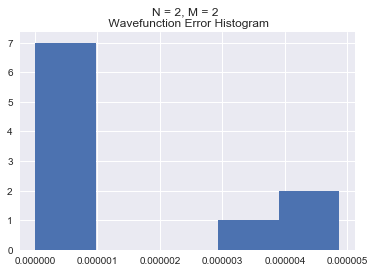

In [42]:
plt.hist(stateErr, bins='auto') 
plt.title("N = 2, M = 2 \n Wavefunction Error Histogram")
plt.show()

In [ ]:
plt.hist(stateErr, bins='auto') 
plt.title("N = 2, M = 2 \n Wavefunction Error Histogram")
plt.show()